In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score

sns.set_context('paper', font_scale=1.76)
sns.set_style('whitegrid')

In [2]:
results_openml = pd.read_csv('../mementoML_results/results.csv')
df_openml = results_openml.copy()
df_openml.columns = ['target', 'set_index', 'AUC']
openml_names = {37: 'diabetes', 44: 'spambase', 1043: 'ada_agnostic', 1046: 'mozilla4', 1049: 'pc4', 1050: 'pc3',
            1063: 'kc2', 1067: 'kc1', 1068: 'pc1', 1120: 'MagicTelescope', 1462: 'banknote-authentication',
            1464: 'blood-transfusion', 1467: 'climate-model', 1471: 'eeg-eye-state',
            1479: 'hill-valley', 1485: 'madelon', 1487: 'ozone-level-8hr', 1489: 'phoneme', 1494: 'qsar-biodeg',
            1504: 'steel-plates-fault', 1510: 'wdbc', 1570: 'wilt'}
df_openml.loc[:, 'target'] = df_openml.loc[:, 'target'].map(openml_names)
df_openml

,target,set_index,AUC
0,diabetes,0,0.768046
1,diabetes,1,0.830233
2,diabetes,2,0.798156
3,diabetes,3,0.813763
4,diabetes,4,0.763103
...,...,...,...
21973,wilt,994,0.828950
21974,wilt,995,0.966634
21975,wilt,996,0.927657
21976,wilt,997,0.978009


In [3]:
results_mimic = pd.read_csv('../3_metaMIMIC_experiment_2/results.csv')
df_mimic = results_mimic.groupby(['set_index', 'target', 'half']).agg({'AUC': 'mean'}).reset_index().copy()
df_mimic = df_mimic.loc[df_mimic['set_index']!=999]
mimic_names = {'hypotension_diagnosed': 'hypotension', 'anemia_diagnosed': 'anemia',
               'purpura_diagnosed': 'purpura', 'respiratory_diagnosed': 'respiratory diseases',
               'hypertensive_diagnosed': 'hypertension', 'lipoid_diagnosed': 'lipoid disorders',
               'diabetes_diagnosed': 'diabetes', 'overweight_diagnosed': 'obesity',
               'alcohol_diagnosed': 'alcohol dependence', 'atrial_diagnosed': 'atrial fibrillation',
               'ischematic_diagnosed': 'ischematic diseases', 'heart_diagnosed': 'heart failure'}
df_mimic.loc[:, 'target'] = df_mimic.loc[:, 'target'].map(mimic_names)
df_mimic

,set_index,target,half,AUC
0,0,alcohol dependence,1,0.853606
1,0,alcohol dependence,2,0.848731
2,0,anemia,1,0.809902
3,0,anemia,2,0.797775
4,0,atrial fibrillation,1,0.886608
...,...,...,...,...
23971,998,obesity,2,0.499758
23972,998,purpura,1,0.502272
23973,998,purpura,2,0.600437
23974,998,respiratory diseases,1,0.499754


In [4]:
df_bayes = pd.read_csv('../6_metaMIMIC_experiment_bayes/results.csv')
df_bayes = df_bayes[df_bayes['half']==1].groupby(['set_index', 'target', 'half']).agg({'AUC': 'mean'}).reset_index()
df_bayes.loc[:, 'target'] = df_bayes.loc[:, 'target'].map(mimic_names)
df_bayes

,set_index,target,half,AUC
0,0,alcohol dependence,1,0.859199
1,0,anemia,1,0.817538
2,0,atrial fibrillation,1,0.884642
3,0,diabetes,1,0.881274
4,0,heart failure,1,0.841861
...,...,...,...,...
1195,99,ischematic diseases,1,0.848657
1196,99,lipoid disorders,1,0.758666
1197,99,obesity,1,0.899583
1198,99,purpura,1,0.904194


In [5]:
data = pd.read_csv('/workspace/official/1_metaMIMIC_data/metaMIMIC.csv')
data.columns = [*data.columns[:-12], *[mimic_names[name] for name in data.columns[-12:]]]
X = data.iloc[:, 1:-12]
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(X)
ys = data.iloc[:, -12:]

cv = StratifiedKFold(n_splits=4, random_state=1, shuffle=True)

In [6]:
def draw_results(ax, target, x_label=True, y_label=True):
    y = ys[target]    
    model = xgb.XGBClassifier(use_label_encoder=False, verbosity=0)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=4)
    mean_baseline_xgb_score = np.mean(scores)

    df_mimic_1 = df_mimic[(df_mimic['target']==target) & (df_mimic['half']==1)]
    df_mimic_2 = df_mimic[(df_mimic['target']==target) & (df_mimic['half']==2)]
    
    theoretical_values = np.zeros(100)
    for i in range(len(theoretical_values)):
        theoretical_values[i] = np.quantile(df_mimic_1['AUC'], 1-(1/(i+2)))
    theoretical_values += df_mimic_1['AUC'].max() - theoretical_values[-1]
    
    openml_values = np.zeros(100)
    openml_ranking = df_openml.assign(auc=df_openml[['target', 'AUC']].groupby('target').transform(lambda x: (x-x.min())/(x.max()-x.min())))
    openml_ranking = openml_ranking.groupby('set_index').agg({'AUC': 'sum'}).sort_values('AUC', ascending=False)
    for i in range(len(openml_values)):
        openml_values[i] = np.max(df_mimic_1[df_mimic_1['set_index'].isin(openml_ranking.iloc[:(i+1), ].index)]['AUC'])

    mimic_halves_values = np.zeros(100)
    mimic_halves_ranking = df_mimic.assign(AUC=df_mimic[['target', 'AUC']].groupby('target').transform(lambda x: (x-x.min())/(x.max()-x.min())))
    mimic_halves_ranking = mimic_halves_ranking[(mimic_halves_ranking['target']!=target) & (mimic_halves_ranking['half']==2)].groupby('set_index').agg({'AUC': 'sum'}).sort_values('AUC', ascending=False)
    for i in range(len(mimic_halves_values)):
        mimic_halves_values[i] = np.max(df_mimic_1[df_mimic_1['set_index'].isin(mimic_halves_ranking.iloc[:(i+1), ].index)]['AUC'])

    mimic_same_values = np.zeros(100)
    mimic_same_ranking = df_mimic.assign(AUC=df_mimic[['target', 'AUC']].groupby('target').transform(lambda x: (x-x.min())/(x.max()-x.min())))
    mimic_same_ranking = mimic_same_ranking[(mimic_same_ranking['target']!=target) & (mimic_same_ranking['half']==1)].groupby('set_index').agg({'AUC': 'sum'}).sort_values('AUC', ascending=False)
    for i in range(len(mimic_same_values)):
        mimic_same_values[i] = np.max(df_mimic_1[df_mimic_1['set_index'].isin(mimic_same_ranking.iloc[:(i+1), ].index)]['AUC'])
    
    df_bayes_ = df_bayes[df_bayes['target'] == target]
    bayes_values = np.zeros(100)
    for i in range(len(bayes_values)):
        bayes_values[i] = np.max([df_bayes_.iloc[i]['AUC'], bayes_values.max()])
    
    x = [i+1 for i in range(100)]

    ax.step(x, mimic_same_values, where='mid', color='C1', label='MIMIC-IV (same observations)')    
    ax.step(x, mimic_halves_values, where='mid', color='C2', label='MIMIC-IV (different observations)')
    ax.step(x, openml_values, where='mid', color='C0', label='OpenML')
    ax.step(x, bayes_values, where='mid', color='C4', label='Bayesian optimisation')
    ax.step(x, theoretical_values, where='mid', color='C5', label='Random search expectation')
    ax.hlines(y = mean_baseline_xgb_score, xmin=1, xmax=100, color='C3', linestyles='dashed', label="XGBoost defaults")
    ax.set_title(f'Task: {target}')
    ax.set_xscale('log')
    if y_label:
        ax.set_ylabel('Best 4-CV ROC AUC')
    if x_label:
        ax.set_xlabel('Number of sets tested (log scale)')

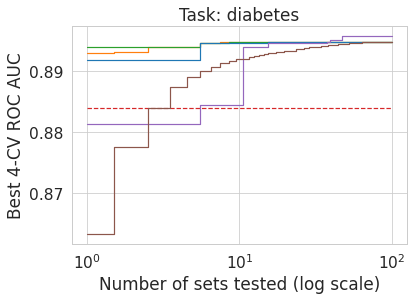

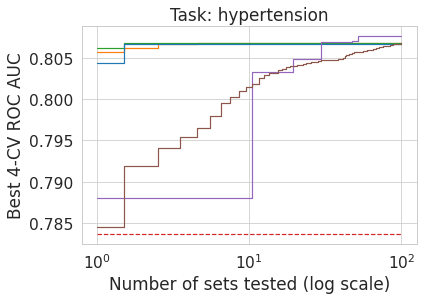

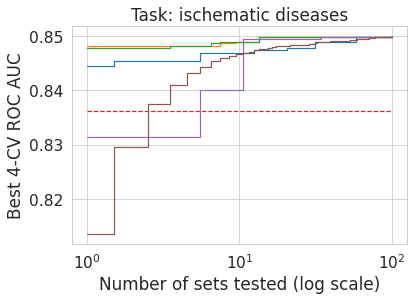

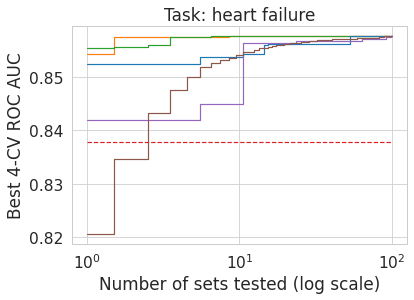

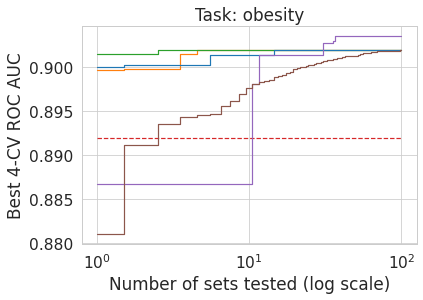

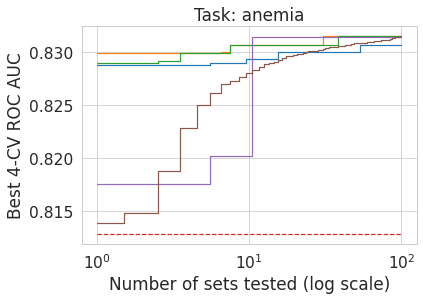

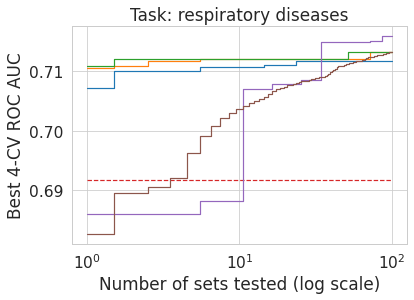

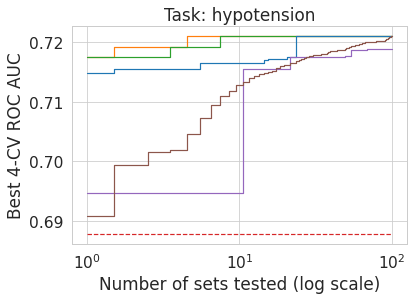

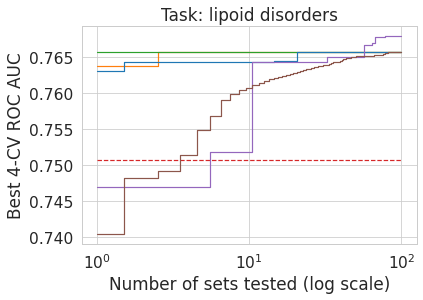

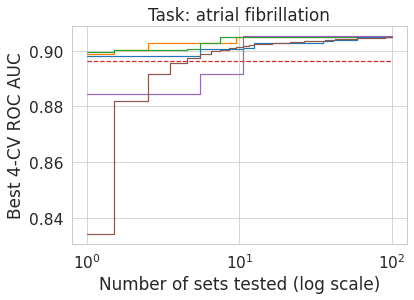

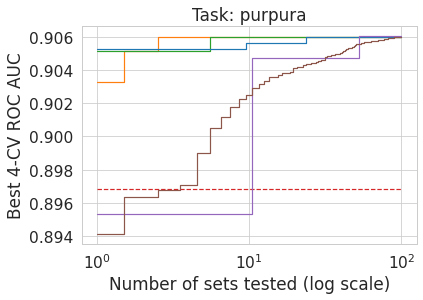

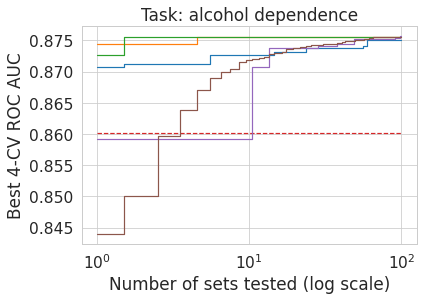

In [7]:
for target in ys.columns:
    fig, ax = plt.subplots()
    draw_results(ax, target)
    plt.show()

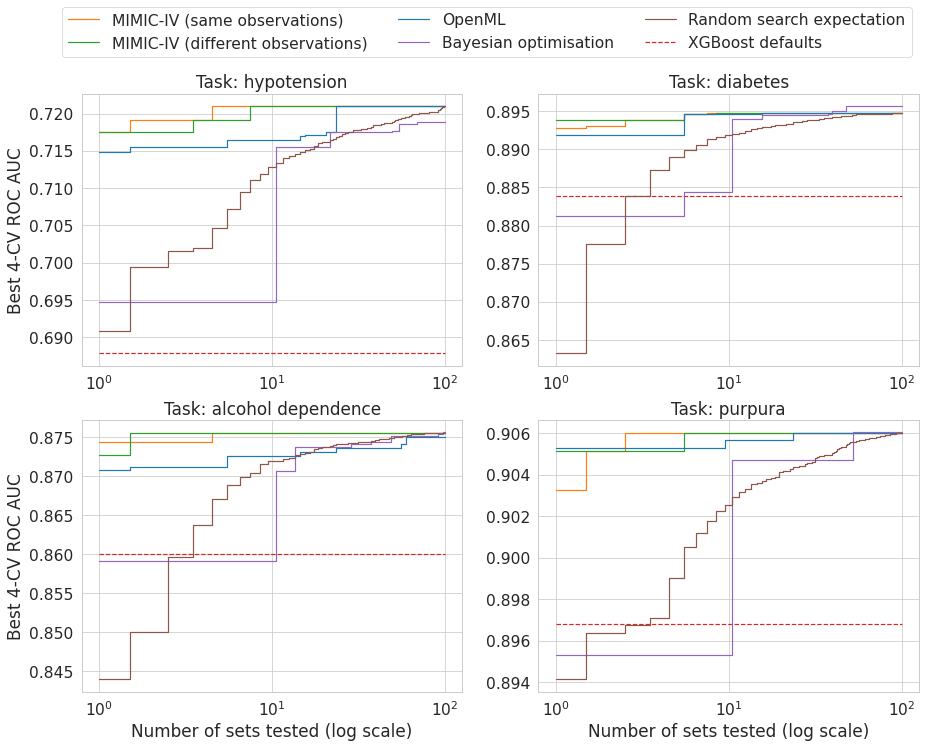

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(15,11))

draw_results(axs[0,0], 'hypotension', x_label=False)
draw_results(axs[0,1], 'diabetes', x_label=False, y_label=False)
draw_results(axs[1,0], 'alcohol dependence')
draw_results(axs[1,1], 'purpura', y_label=False)

handles_, labels_ = axs[0,0].get_legend_handles_labels()
fig.legend(handles_, labels_, loc='upper center', bbox_to_anchor=(0.5, 1.0), fancybox=True, ncol=3)

plt.savefig('./results_3.pdf', format='pdf', bbox_inches='tight')